In [1]:
from google.colab import drive
import os
if 'google.colab' in str(get_ipython()):
  drive.mount('/content/gdrive')
  os.chdir('/content/gdrive/MyDrive/Benchmarking-Distributional-Alignment-of-Small-Language-Models')

Mounted at /content/gdrive


In [2]:
import os
from google.colab import userdata
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [3]:
!pip install --upgrade -q transformers huggingface_hub peft \
  accelerate bitsandbytes datasets trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 re

In [4]:
from huggingface_hub import login
import tensorflow as tf
login(os.environ["HF_TOKEN"])
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# Run random baseline to get these files first!
n_training_qIDs = "train_qIDs.json"
n_testing_qIDs = "test_qIDs.json"

# demographic group and output type
demographic_group = "POLPARTY"
demographic = "Republican"
output_type = "sequence"

In [6]:
model_id = "google/gemma-2-2b-it"
device = "cuda"

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Let's quantize the model to reduce its weight
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Let's load the final model
model = AutoModelForCausalLM.from_pretrained(
    model_id, device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.gradient_checkpointing_enable()

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [8]:
from utils import *
import json

sampled_qIDs = json.load(open(n_training_qIDs))

qID_datasets = []
for qID in sampled_qIDs:
    qID_dataset = get_few_shot_training_examples(
        qID,
        wave="Pew_American_Trends_Panel_disagreement_100",
        demographic_group=demographic_group,
        demographic=demographic,
        output_type=output_type,
        dataset="opinionqa",
        n_shots=5,
        n_simulations_per_shot=1,
    )
    qID_datasets += [qID_dataset]
raw_dataset = pd.concat(qID_datasets)
training_dataset = prepare_df(raw_dataset.copy(), tokenizer).reset_index(drop=True)
training_dataset.head(3)

/content/gdrive/MyDrive/Benchmarking-Distributional-Alignment-of-Small-Language-Models/utils.py:138: RuntimeWarning: invalid value encountered in divide
  icl_values = np.array(icl_values)/np.sum(icl_values)


,input,output,qID,icl_qID,demographic_group,demographic,output_type,wave
0,<start_of_turn>user\nPlease simulate 30 sample...,Answer: D D D B C B C D C D D D A C D B D B D ...,SOCIETY_SSM_W92,GAYMARR2_W32,POLPARTY,Republican,sequence,Pew_American_Trends_Panel_disagreement_100
1,<start_of_turn>user\nPlease simulate 30 sample...,Answer: C C E D B B C B E C E D C B B B B E C ...,SOCIETY_SSM_W92,FAMSURV6_W50,POLPARTY,Republican,sequence,Pew_American_Trends_Panel_disagreement_100
2,<start_of_turn>user\nPlease simulate 30 sample...,Answer: F A E C C C C C F A F E D E A D D E A ...,SOCIETY_SSM_W92,SOCIETY_RHIST_W92,POLPARTY,Republican,sequence,Pew_American_Trends_Panel_disagreement_100


In [42]:
# Function to dynamically gather data and create preference pairs
def create_republican_preference_pairs(sampled_qIDs, demographic_group, output_type):
    """
    Dynamically create preference pairs with "Republican" as the preferred demographic.
    Args:
        sampled_qIDs (list): List of qIDs to gather data for.
        demographic_group (str): The demographic group key (e.g., "POLPARTY").
        output_type (str): Output type for the task (e.g., "sequence").
    Returns:
        pd.DataFrame: A DataFrame containing preference pairs with Republican as the preferred input.
    """
    # Target demographic
    target_demographic = "Republican"
    other_demographic = "Democrat"
    unique_demographics = {target_demographic, other_demographic}
    if target_demographic not in unique_demographics or other_demographic not in unique_demographics:
        raise ValueError("Required demographic groups are missing.")
    group_datasets = {}
    for demographic in unique_demographics:
        group_datasets[demographic] = []
        for qID in sampled_qIDs:
            group_data = get_few_shot_training_examples(
                qID,
                wave="Pew_American_Trends_Panel_disagreement_100",
                demographic_group=demographic_group,
                demographic=demographic,
                output_type=output_type,
                dataset="opinionqa",
                n_shots=5,
                n_simulations_per_shot=1,
            )
            group_datasets[demographic].append(group_data)
        group_datasets[demographic] = pd.concat(group_datasets[demographic])
    pairs = []
    for _, preferred_row in group_datasets[target_demographic].iterrows():
        for _, less_preferred_row in group_datasets[other_demographic].iterrows():
            pairs.append({
                "preferred_input": f"{preferred_row['input']} Answer:",
                "preferred_output": preferred_row["output"].replace("Answer: ", ""),
                "less_preferred_input": f"{less_preferred_row['input']} Answer:",
                "less_preferred_output": less_preferred_row["output"].replace("Answer: ", ""),
            })

    return pd.DataFrame(pairs)

republican_preference_dataset = create_republican_preference_pairs(
    sampled_qIDs=sampled_qIDs,
    demographic_group="POLPARTY",
    output_type="sequence"
)
republican_preference_dataset.head(3)


/content/gdrive/MyDrive/Benchmarking-Distributional-Alignment-of-Small-Language-Models/utils.py:138: RuntimeWarning: invalid value encountered in divide
  icl_values = np.array(icl_values)/np.sum(icl_values)


,preferred_input,preferred_output,less_preferred_input,less_preferred_output
0,Please simulate 30 samples from a group of Rep...,D B B B D D D B C B B D B B D D B D D A D D C ...,Please simulate 30 samples from a group of Dem...,E E C E E B B E D D E E E E D E E E D E C B E ...
1,Please simulate 30 samples from a group of Rep...,D B B B D D D B C B B D B B D D B D D A D D C ...,Please simulate 30 samples from a group of Dem...,B D D B D D D D B D D C C B D D D D D D D D B ...
2,Please simulate 30 samples from a group of Rep...,D B B B D D D B C B B D B B D D B D D A D D C ...,Please simulate 30 samples from a group of Dem...,F F A D F F F F F A F F F F D F F F D F F F A ...


In [43]:
from datasets import Dataset
def prepare_dpo_dataset(preference_dataset):
  dpo_format = {
    "prompt": [],
    "chosen": [],
    "rejected": []
  }

  for _, row in preference_dataset.iterrows():
    dpo_format["prompt"].append(row["preferred_input"])
    dpo_format["chosen"].append(row["preferred_output"])
    dpo_format["rejected"].append(row["less_preferred_output"])

  return Dataset.from_dict(dpo_format)
dpo_dataset = prepare_dpo_dataset(preference_dataset)

# Fine-tune and prompting the fine-tuned model

In [44]:
from trl import DPOTrainer
import torch
from transformers import TrainingArguments
from peft import LoraConfig

lora_config = LoraConfig(
    r=4,
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "o_proj",
        "k_proj",
        "v_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
)

In [45]:
from datasets import load_dataset
from trl import DPOConfig, DPOTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.cuda.empty_cache()
training_args = DPOConfig(
    output_dir="checkpoint",
    logging_steps=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_steps=10,
    max_steps=100,
    learning_rate=1e-4)
# collator = PreferenceCollator(pad_token_id=0)
trainer = DPOTrainer(
    model=model,
    args=training_args,
    processing_class=tokenizer,
    train_dataset=dpo_dataset,
    peft_config=lora_config,
    # data_collator=collator,
)

Extracting prompt from train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [46]:
trainer.model.print_trainable_parameters()

trainable params: 5,191,680 || all params: 2,619,533,568 || trainable%: 0.1982


In [47]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
10,0.692200
20,0.652800
30,0.595700
40,0.453600
50,0.492600
60,0.379500
70,0.359400
80,0.267900
90,0.202200
100,0.274000


TrainOutput(global_step=100, training_loss=0.43699595928192136, metrics={'train_runtime': 215.5357, 'train_samples_per_second': 3.712, 'train_steps_per_second': 0.464, 'total_flos': 0.0, 'train_loss': 0.43699595928192136, 'epoch': 0.16})

In [48]:
def apply_chat_template(row):
    messages = [{"role": "user", "content": row["input"]}]
    nobos = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)[1:]
    return tokenizer.decode(nobos)

test_pool = get_test_questions_with_distributions(
    seen_qIDs={},
    demographic_group=demographic_group,
    demographic=demographic,
)
test_qIDs = json.load(open(n_testing_qIDs))

In [49]:
k = 1
success_rates = []
probabilities_list = []
for test_qID in test_qIDs:
    print("Evaluating:", test_qID)
    # test_qID = "ECON5_d_W54"
    n = (sum(test_pool[test_qID][demographic].values()))
    MC_options = list(test_pool[test_qID][demographic].keys())
    all_options, probs = [], []
    for i, option in enumerate(MC_options):
        all_options.append(options[i])
        probs.append(test_pool[test_qID][demographic][option]/n)
    golden_dist = dict(zip(all_options, probs))
    instruction = get_zeroshot_prompt_opinionqa(test_qID, output_type="sequence")

    instruction = apply_chat_template({"input": instruction})
    model_inputs = tokenizer(instruction, return_tensors="pt").to(device)
    successful_parsings = 0
    total_attempts = 0
    while successful_parsings < k:
      outputs = model.generate(
        **model_inputs,
        max_new_tokens=36,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        early_stopping=True
      )
      response = tokenizer.decode(outputs[0][model_inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
      print(response)
      success, result = parse_answers(response, all_options, answer_tag=False)
      total_attempts += 1
      if success:
          successful_parsings += 1
          probabilities_list.append([golden_dist, result["probabilities"]])
      success_rate = successful_parsings / total_attempts
      success_rates += [success_rate]
success_rate = np.array(success_rates).mean()
print("Success rate:", success_rate)

Evaluating: WHYNOTBIZF2G_W36


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


A. Major reason. 
B. Minor reason.
C. Not a reason.
D. Refused. 

Please understand that this is only an example and
A. Major reason. 
B. Major reason.
C. Not a reason.
D. Refused. 
 
  
  

A. Major reason. 
B. Major reason.
C. Major reason.
D. Refused
 
...

This is a trick question. 

A:  D. Refused. 
B:  D. Refused.
C. D. Refused. 
D. D. Refused.


C. Not a reason. 
B. Minor reason. 
C. Not a reason. 
B. Minor reason. 
C. Not a reason.
A.  Major reason. 
B. Minor reason.
C. Not a reason. 
D. Refused. 
 
 
Let me know
A- B- C- D 
B- D- C 
C- D- B 
D- A - C 
A - C - B 
Evaluating: GAP21Q33_r_W82
B. Refused. 
B. Refused. 
C. Some priority. 
D. Top priority. 
B. Refused.
C.
B. Refused. C. Some priority. D. Top priority. 
 

B. Refused. 
B. Refused. 
C. Some priority. 
D. Top priority. 
B. Refused.   
D
B. Refused. 
C. Some priority.
D. Top priority.
 
 

B. Refused. 
B. Refused. 
D. Top priority
C. Some priority
A. None
B. Refused 
C.
B 
C 
D 
B 
C 
D 
B 
C 
D 
B 
C 
D 

Evaluating: NE

In [ ]:
distances = compute_l1_values(probabilities_list)

In [51]:
json.dump(distances, open("distance_lora_dpo.json", "w"))

In [55]:
instruction = "Tell me about US politics."

instruction = apply_chat_template({"input": instruction})
model_inputs = tokenizer(instruction, return_tensors="pt").to(device)

outputs = model.generate(
    **model_inputs, max_new_tokens=128, do_sample=True,
    eos_token_id=tokenizer.eos_token_id, early_stopping=True
)
response = tokenizer.decode(outputs[0][model_inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
print(response)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


## US Politics: A Complex Tapestry 🧵

US Politics is a massive topic. Here's a breakdown to start us off:

**1. The Political Landscape:** 

* **Two-Party System:**  The dominant structure, with Democrats and Republicans vying for power. 
* **Minor parties:** Exist, but struggle to gain significant national traction. They play smaller roles in the government.
* **Party Organization:** Each has a national apparatus, state-level structures, and local chapters.

**2. Legislative Branch:**
* **Congress:** The House of Representatives and the Senate are responsible for creating laws


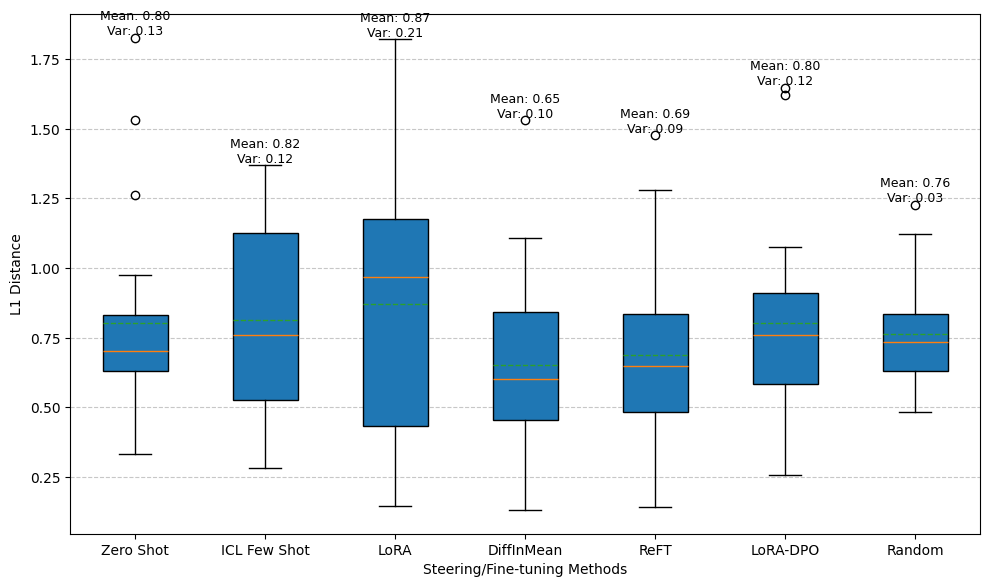

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with the paths to your JSON files
json_files = ['distance_zs.json', 'distance_icl.json', 'distance_lora.json', 'distance_reft.json', 'distance_reps.json', 'distance_lora_dpo.json', 'distance_random.json']
data = []
for file in json_files:
    with open(file, 'r') as f:
        data.append(json.load(f))

# Calculate means and variances for each dataset
means = [np.mean(d) for d in data]
variances = [np.var(d) for d in data]

# Create the box plot
plt.figure(figsize=(10, 6))
box = plt.boxplot(data, patch_artist=True, showmeans=True, meanline=True)

# Annotate mean and variance
for i, (mean, var) in enumerate(zip(means, variances), start=1):
    plt.text(i, max(data[i - 1]), f'Mean: {mean:.2f}\nVar: {var:.2f}', ha='center', va='bottom', fontsize=9)

# Customize plot
plt.title('')
plt.xlabel('Steering/Fine-tuning Methods')
plt.ylabel('L1 Distance')
plt.xticks(range(1, len(json_files) + 1), ["Zero Shot", "ICL Few Shot", "LoRA", "DiffInMean", "ReFT", "LoRA-DPO", "Random"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# ["Random", "Zero Shot", "ICL Few Shot", "LORA", "Reft", "Reps"]